In [51]:
import pickle
import keras
import os
import pandas as pd
import numpy as np
import re
from time import time
import matplotlib.pyplot as plt
import cv2
import math

from keras.applications.inception_v3 import preprocess_input
from modules.generators import ImageSequence


DEFAULT_SAVE_PATH_MODEL     = 'model_inception_v3_mixedlayeroutputs_auto.h5'
DEFAULT_IMAGE_DIRECTORY     = 'images/color/session1_memory/original'


SAVE_PATH_MODEL = ''
IMAGE_DIRECTORY = ''
SAVE_DATA_PATH = ''


In [2]:
def get_model(load_path = None, auto_save = True):
    """Loads or instantiates a model based on inception_v3 returning the
    outputs of all 11 mixed layers with indices from 0 to 10.

    Arguments:
        load_path: path of the already instantiated saved model.

        auto_save: if True, saves the model in the default save path, if model
        was not loaded.

    Returns:
        a keras model with all full mixed layers of inception_V3 as output
    """

    if load_path is None:
        if SAVE_PATH_MODEL == '':
            load_path = DEFAULT_SAVE_PATH_MODEL
        else:
            load_path = SAVE_PATH_MODEL
    try:
        model = keras.models.load_model(load_path)

    except OSError:
        inc_v3 = keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')

        def get_mixed_layer_names():
            layer_names = []
            for layer in inc_v3.layers:
                if 'mixed' in layer.name:
                    layer_names.append(layer.name)
            return layer_names

        mixed_layer_names = get_mixed_layer_names()

        main_mixed_layer_names = [ln for ln in mixed_layer_names if '_' not in ln]

        x = inc_v3.input
        outs = []
        for ln in main_mixed_layer_names:
            outs.append(inc_v3.get_layer(ln).output)
        model = keras.Model(inputs=x, outputs=outs)
        if auto_save:
            model.save(DEFAULT_SAVE_PATH_MODEL, include_optimizer=False)
    return model

In [3]:
def get_img_paths(start_dir, extensions = ['png']):
    """Returns all image paths with the given extensions in the directory.

    Arguments:
        start_dir: directory the search starts from.

        extensions: extensions of image file to be recognized.

    Returns:
        a sorted list of all image paths starting from the root of the file
        system.
    """
    if start_dir is None:
        start_dir = os.getcwd()
    img_paths = []
    for roots,dirs,files in os.walk(start_dir):
        for name in files:
            for e in extensions:
                if name.endswith('.' + e):
                    img_paths.append(roots + '/' + name)
    img_paths.sort()
    return img_paths

In [4]:
def data_selecting(data,color,masktype,maskregion,fixincalid):
    """choose the data associated to different experiment settings

    Arguments:
        data:

            ...

    Returns:
        DataFrame
    """
#masktype == 0 & maskregion == 0: Kontrollbedingung
    cleaned_data = data.loc[(data["colorimages"] == color) &
                         (data["masktype"]    == masktype) &
                         (data["maskregion"]  == maskregion) &
                         (data["fixinvalid"]  == fixincalid) ,
                         ['subject',
                          'fixposx',
                          "fixno",
                          "fixposy",
                          "imageid",
                          "masktype",
                          "maskregion",
                          "fixinvalid",
                          "colorimages"]]
    return cleaned_data

In [5]:
def get_eyemovements(dataFrame):
    """Take a DataFrame from Eyemovement Experiment and returns the list
       eyemovemts. Preprozessing for

    Input: Selected Experment DataFrame

    Returns: DataFrame with lists of Eyemovement

    """

    ###create list of eyemovements
    list_of_ey_x = dataFrame.groupby("imageid")["fixposx"].apply(list)
    list_of_ey_y = dataFrame.groupby("imageid")["fixposy"].apply(list)
    list_of_ey_xy = pd.concat([list_of_ey_x,list_of_ey_y], axis = 1)

    return list_of_ey_xy

In [6]:
file_pictures = "blickdaten/finalresulttab_funcsac_SFC_memory.dat"
all_data = pd.read_table(file_pictures,encoding = "ISO-8859-1")

fovea = 30

all_data = all_data.loc[
                      (all_data["fixposx"] >= fovea) &
                      (all_data["fixposx"] <= 1024 - fovea) &
                      (all_data["fixposy"] >= fovea) &
                      (all_data["fixposy"] <= 768 - fovea)
                      ]


#masktype == 0 & maskregion == 0: Kontrollbedingung
exp_control_color = data_selecting(all_data,1,0,0,0)

In [7]:
exp_control_color.head()

,subject,fixposx,fixno,fixposy,imageid,masktype,maskregion,fixinvalid,colorimages
0,1,529.1,1.0,395.3,91,0,0,0,1
1,1,671.9,2.0,481.6,91,0,0,0,1
5,1,949.5,6.0,439.7,91,0,0,0,1
6,1,935.3,7.0,383.4,91,0,0,0,1
7,1,555.2,8.0,379.4,91,0,0,0,1


In [8]:
model = get_model()

/home/mendel/.conda/envs/work/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [9]:
if IMAGE_DIRECTORY == '':
    img_paths = get_img_paths(DEFAULT_IMAGE_DIRECTORY)
else:
    img_paths = get_img_paths(IMAGE_DIRECTORY)

In [10]:
#preprocess
img_sequ = ImageSequence(paths = img_paths,
                         labels = None,
                         batch_size = 1,
                         preprocessing=preprocess_input,
                         augmentation=[])

In [11]:
iter_ = img_sequ.__iter__()
image = iter_.__next__()

#for i,image in enumerate(img_sequ): 
#    if i >= len(img_sequ):
    #if i >= 1:
#       break


t_start_model_predict = time()
#running the images through the model and get the leyers
p = model.predict(image, batch_size = 1)
t_stop_model_predict = time()

In [12]:
type(p)
len(p)

11

## Original

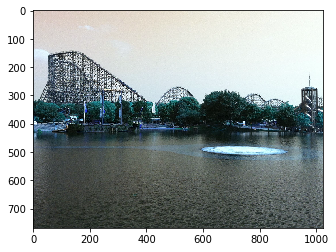

In [13]:
pic1 = cv2.imread("images/color/session1_memory/original/1.png")
plt.imshow(pic1)

## Layer 1

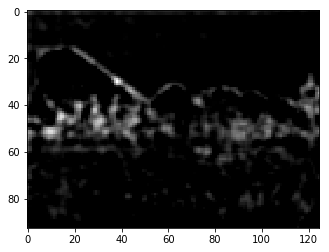

In [14]:
plt.imshow(p[0][0][:,:,254], interpolation="nearest", cmap="gray")

## Layer 2

(1, 22, 30, 2048)


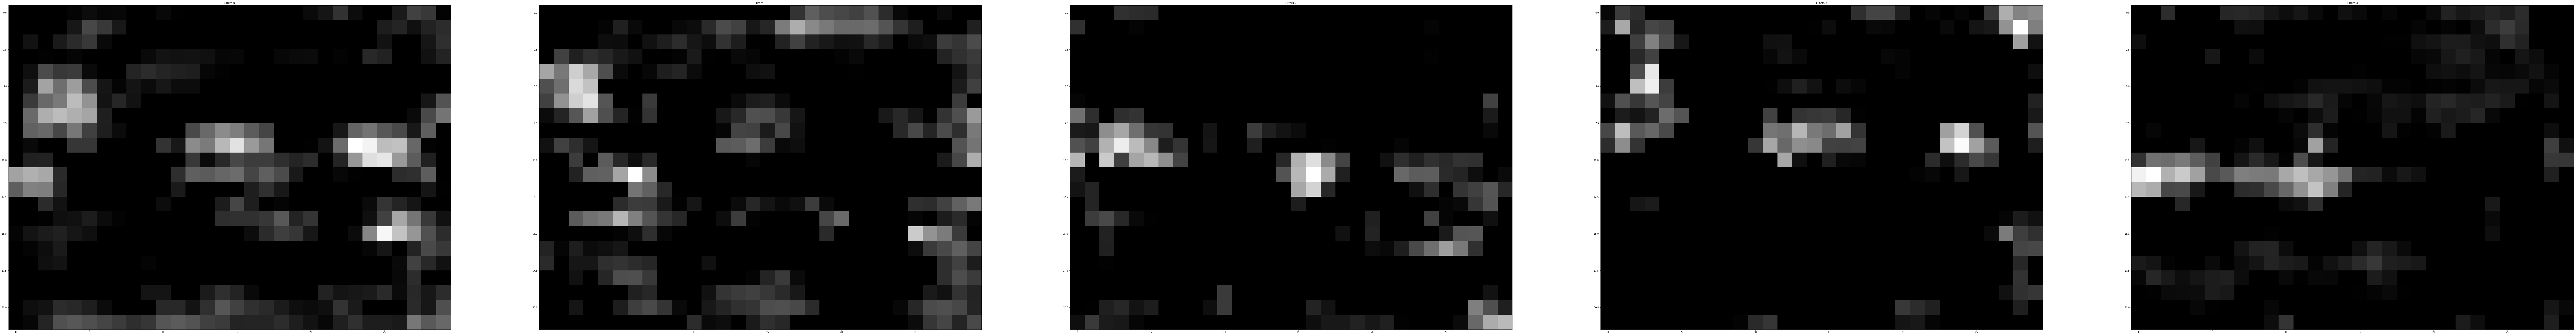

In [27]:
layer = 11
plt.figure(1, figsize=(200,200))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Filters ' + str(i))
    plt.imshow(p[layer-1][0][:,:,i], interpolation="nearest", cmap="gray")
print(p[layer-1].shape)

In [48]:
np.mean(p[layer-1][0][:,:], axis=2).shape

(22, 30)

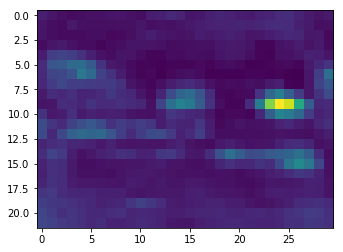

In [50]:
plt.imshow(np.max(p[layer-1][0][:,:], axis=2))

In [16]:
pic1 = cv2.imread("images/color/session1_memory/original/1.png")


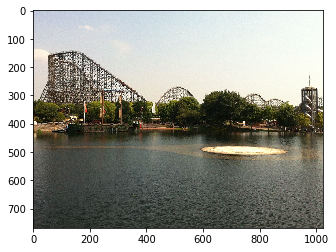

In [54]:
list_of_ey_xy = get_eyemovements(exp_control_color)

pic1 = plt.imread("images/color/session1_memory/original/1.png")

meanlist = []
rlist    = []
fixations = list_of_ey_xy.iloc[0,0]
for i in range(len(list_of_ey_xy.iloc[0,0])):   
    d = pic1[int(list_of_ey_xy.iloc[0,1][i])-fovea:
             int(list_of_ey_xy.iloc[0,1][i])+fovea,
             int(list_of_ey_xy.iloc[0,0][i])-fovea:
             int(list_of_ey_xy.iloc[0,0][i])+fovea]
    rlist.append(d)
    if(d.shape == (60,60,3)):
        meanlist.append(d)

plt.imshow(pic1)

In [53]:
pic1.shape

(768, 1024, 3)

x:  424.1
y:  304.5


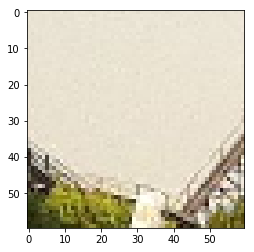

In [74]:
#Fixationsnummer
z = 9
print("x: ",list_of_ey_xy.iloc[0,0][z])
print("y: ",list_of_ey_xy.iloc[0,1][z])
plt.imshow(meanlist[z])

x:  781.9
y:  502.1


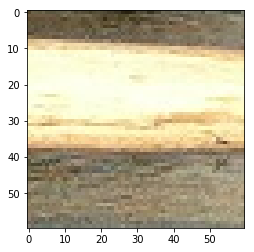

In [64]:
#Fixationsnummer
z = 5
print("x: ",list_of_ey_xy.iloc[0,0][z])
print("y: ",list_of_ey_xy.iloc[0,1][z])
plt.imshow(meanlist[z])

In [57]:
len(rlist)

249

In [58]:
len(meanlist)

249

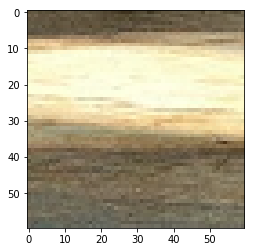

In [61]:
#Blick 4 + 5
plt.imshow(np.mean(meanlist[4:6], axis=0))

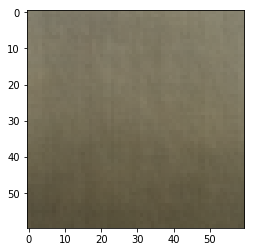

In [62]:
#gesammt durchscnitt
plt.imshow(np.mean(meanlist, axis=0))

In [24]:
np.mean(meanlist, axis=0).shape

(60, 60, 3)

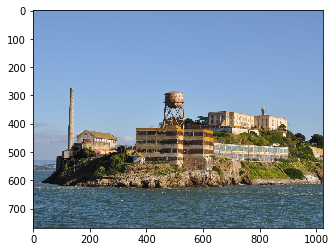

In [75]:
list_of_ey_xy = get_eyemovements(exp_control_color)

pic2 = plt.imread("images/color/session1_memory/original/2.png")

meanlist2 = []
fixations = list_of_ey_xy.iloc[0,0]
for i in range(len(list_of_ey_xy.iloc[0,0])):   
    d = pic2[int(list_of_ey_xy.iloc[0,1][i])-fovea:
             int(list_of_ey_xy.iloc[0,1][i])+fovea,
             int(list_of_ey_xy.iloc[0,0][i])-fovea:
             int(list_of_ey_xy.iloc[0,0][i])+fovea]
    if(d.shape == (60,60,3)):
        meanlist2.append(d)

plt.imshow(pic2)

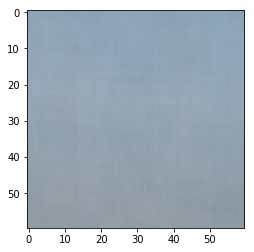

In [76]:
plt.imshow(np.mean(meanlist2, axis=0))

Interpolation: With and Without